# PDE Modelling 

## Objectives 
* Make a model that describes cell growth and signalling at the scale of colonies 

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. Environmental AHL (considered equal to intracellular concentration)
    1. Synthase / sfCFP
    1. Repressor / mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Transcriptional activation
        * Basal protein expression -> scaled by repression? probably
        * Activation by internal AHL 
        * Use Hill function $$H(A(t), n, k) = \frac{A(t)^n}{k^n + A(t)^n}$$
        * Activation term, with basal expression and expression rate x
        $$X(A(t), n, k, b, x) = x\frac{A(t)^2}{k^n + A(t)^n} + b$$
    1. Transcriptional repression
        * Assume activation is AND-like, meaning that repression trumps activation
        * Use 'repression' Hill function $$H_n(R(t), n, k) = \frac{k^n}{k^n + R(t)^n}$$
        * Rather than considering protein concentrations within cells, calculate protein concentrations as produced by the bulk of cells. Expression is therefore proportional to cell density.
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xa : Synthesis rate of AHL. units of $\frac{nM}{au \cdot  min}$
        * xs : Expression rate of protein. units of $\frac{au}{OD \cdot min}$
        * ha : Hill coefficient of AHL-inducible expression. unitless
        * ka : Half-point of AHL-inducible expression. units of $\frac{OD}{au}$
        * pa : Degradation rate of AHL. units of $\frac{1}{min}$
        * leak : Leaky expression rate of protein. units of $\frac{au}{OD \cdot min}$
        


In [1]:
# imports
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi

import matplotlib as mpl
import seaborn as sns
import itertools

import matplotlib.pyplot as plt 
import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

%load_ext line_profiler

import bokeh
from bokeh.plotting import figure, output_file, save
from bokeh.io import output_notebook, show
from bokeh import palettes, transform
from bokeh.models import LogColorMapper, LogTicker, ColorBar, LinearColorMapper, Ticker
output_notebook()

from IPython.display import HTML

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('paper', rc=rc)

%matplotlib inline

Loading BokehJS ...

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

In [2]:
# Universal constants
species = 6
scale_s = 0.5
scale = 10
rtol = 1e-3
col_thresh = 0.01
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(species)
cell_inds = [cs_i, cp_i]
ahl_inds = [a_i]
syn_inds = [r_i]


def disk(A, center, radius):
    h, w = A.shape
    ind_mat = np.zeros((h, w, 2))
    cx, cy = center
    for i in range(h):
        ind_mat[i,:,0] = np.power(np.arange(w) - cx, 2)
    
    for i in range(w):
        ind_mat[:,i,1] = np.power(np.arange(h) - cy, 2)
    
    outmat = (ind_mat[:,:,0] + ind_mat[:,:,1]) < radius**2
    return outmat

# units : L = mm, T = minutes, concentration in nM = moles / mm^3
# Da = 6 - 1.2 E-2
#LEGACY
# Params :    dx,                          Dc,    rc,   Kn,   Dn,   kn,  Da,  xa,  xs,  ha,  ka, 
#p0 = np.array([np.power((scale/2.25),2),   1e-4, 6e-3, 75,  8e-3,  2, 8e-2, 1e3, 2e-0, 2.3, 40,    
          # pa,   leak   od0
#             5e-5, 1e-8, 0.5], dtype=np.float32)


# Params :    ,           dx               Dc,       rc,  rp,   Kn,   Dn,    kn, Da,  xa,   xs,  xS,
p0 = np.array([np.power((scale/4.5),2),   1e-4,    8e-3,  8e-3, 15,  3e-2,  1, 3e-2, 8, 5e4, 2e2, 
#xr,   hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   od0
1.2e3, 3.2, 100, 2.3, 55, 3.2, 2.7e3, 5e-3, 1e-8, 0.1], dtype=np.float32)
dx,Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,od0 =p0

col_thresh = 0

#@numba.jit('void(float32[:,:,:],float32[:,:,:])', nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def calc_diffusion(A, D):
    # Middle
    D[:,1:-1,1:-1] = A[:,1:-1, 2:] + A[:,1:-1, :-2] + A[:,:-2, 1:-1] + A[:,2:, 1:-1] - 4*A[:,1:-1, 1:-1]
    # Edges
    D[:,0,1:-1] = A[:,0, 2:] + A[:,0, :-2] + A[:,1, 1:-1] - 3*A[:,0, 1:-1]
    D[:,-1,1:-1] = A[:,-1, 2:] + A[:,-1, :-2] + A[:,-2, 1:-1] - 3*A[:,-1, 1:-1]
    D[:,1:-1,0] = A[:,2:,0] + A[:,:-2,0] + A[:,1:-1,1] - 3*A[:,1:-1,0]
    D[:,1:-1,-1] = A[:,2:,-1] + A[:,:-2,-1] + A[:,1:-1,-2] - 3*A[:,1:-1,-1]
    # Corners
    D[:,0,0] = A[:,0,1] + A[:,1,0] - 2*A[:,0,0]
    D[:,-1,0] = A[:,-1,1] + A[:,-2,0] - 2*A[:,-1,0]
    D[:,0,-1] = A[:,0,-2] + A[:,1,-1] - 2*A[:,0,-1]
    D[:,-1,-1] = A[:,-1,-2] + A[:,-2,-1] - 2*A[:,-1,-1]

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hill(a, n, k):
    h_ma = 1 - (1 / (1 + (a/k)**n))
    return h_ma

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

#@numba.jit('void(float32[:,:,:],float32[:,:,:],float32[:,:,:],float32[:,:])',nopython=True, cache=True)
# @numba.jit(nopython=True, cache=True)
@numba.jit(cache=True)
def calc_f(y, d_y, diff_terms, nut_avail, p0):
    rp,    Kn,  Dn,   Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    calc_diffusion(y, diff_terms)
    
    # Growth term
    nut_avail[:] = hill(y[n_i,:,:], 2.5, Kn)
    
    # Cell growth and diffusion
    for ind in cell_inds:
        d_y[ind,:,:] = nut_avail * y[ind,:,:]
    
    # Nutrient consumption
    d_y[n_i,:,:] = Dn*diff_terms[n_i,:,:] - nut_avail * y[cell_inds,:,:].sum(axis=0)
    
    # AHL production
    d_y[a_i,:,:] = Da*diff_terms[a_i,:,:] + y[s_i,:,:]*y[cell_inds,:,:].sum(axis=0) - pa * y[a_i,:,:]
    
    # Synthase production
    d_y[s_i,:,:] = (
        xs * np.greater(y[cp_i,:,:],col_thresh) * hill(y[a_i,:,:], hS, 1) * hillN(y[r_i,:,:], hC, 1) + 
        xS * np.greater(y[cs_i,:,:],col_thresh) - 
        y[s_i,:,:]
        ) * nut_avail - rp * y[s_i,:,:]
    
    # Repressor production
    d_y[r_i,:,:] = (
        xr * np.greater(y[cp_i,:,:],col_thresh) * hill(y[a_i,:,:], hR, kR) -
        y[r_i,:,:]
        ) * nut_avail - rp * y[r_i,:,:]

@numba.jit
def f_ivp(t, y, d_y, diff_terms, nut_avail, p0):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    
    return d_y.flatten()


In [3]:
def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A


def sim_omnitray(dims, p0, tmax, initial_array, atol): 
    species, n_h, n_w = dims
    args=(np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape[1:], dtype=np.float32,order='C'), 
          p0)
    initial_array.shape = n_h*n_w*species
#     print('Starting')
    f_lambda = lambda t, y : f_ivp(t, y, *args)
    out = itg.solve_ivp(f_lambda, [0, tmax], initial_array, vectorized=True, method='RK23', 
                        atol=atol, rtol=rtol)#, t_eval=np.arange(tmax))
#     print('DONE')
    return out


def wrapper(p, atol):
    cs_spots, cp_spots, ahl_spots, p0, dims = p
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    initial_array = np.zeros((species, n_h, n_w), dtype=np.float32, order='C')# + 1e-7
    initial_array[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)
    initial_array = prep_initial_condition(cs_spots, cp_spots, [], dims,p0, A=initial_array)
    out = sim_omnitray(dims, p0, initial_array=initial_array, tmax=10*60*rc, atol=atol)
#     out = sim_omnitray(dims, p0, initial_array=initial_array, tmax=1, atol=atol)
    exp_t = out.t
    exp_y = out.y.T
    exp_y.shape = (len(exp_t), species, n_h, n_w)
    return exp_y, exp_t
    
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    plt.close('all')
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([n_h, n_w])
    fig, axs = plt.subplots(3,2, figsize=(10,8))
    im_list = [0,0,0,0,0,0,0]
    
    # Plot cell densities
    ax = axs[0,0]
    indxs = [cs_i, cp_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[0,1]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[1,0]
    indxs = [s_i]
    v_arr = im_arr[:,indxs,:,n_w//3:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im
    
    # Plot AHL densities
    ax = axs[1,1]
    indxs = [a_i]
    v_arr = im_arr[-10,indxs,:,:].sum(axis=0)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('AHLs')
    im_list[3] = im
    
    # Plot colony masks
    ax = axs[2,0]
    indxs = [cs_i, cp_i]
    vmax = 50
    vmin = 0
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('masks')
    im_list[4] = im
    
    # Plot represors masks
    ax = axs[2,1]
    indxs = [r_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('repressors')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0,0]
        indxs = [cs_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[0,1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[1,0]
        indxs = [s_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)

        # Plot ahl densities
        ax = axs[1,1]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot colony masks
        ax = axs[2,0]
        indxs = [cs_i, cp_i]
        frame_arr = im_arr[i, indxs, :, :].sum(axis=0) > col_thresh
        frame_arr[:,:np.int(n_w/2)] = 0
        mask, labls = skimage.measure.label(frame_arr,return_num=True, connectivity=1) 
        im_list[4].set_array(mask)
        
        # Plot repressors 
        ax = axs[2,1]
        indxs = [r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[5].set_array(frame_arr)
        
        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())


# Take a look at one frame
out.resize((t_points,species,n_h,n_w))

print(out.shape)

plt.close('all')
fig, axs = plt.subplots(1,species, figsize=(19,5))
for i in np.arange(species):
    ax = axs[i]
    img = ax.imshow(out[-1,i,:,:], interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = fig.colorbar(mappable=img, ax=ax)
plt.show()

t_i = np.arange(im_t)[colony_mean[:,0].max() == colony_mean[:,0]]
masks, ls = skimage.measure.label(
    np.logical_xor(im_arr[t_i, 0, :, :] > 0.12, 
                   im_arr[t_i, 1, :, :] > 0.12), 
    connectivity=1, 
    return_num=True)
labels_vec[t_i] = labels
plt.imshow(masks[0])
print(ls)

In [4]:
def sim(n_h, n_w, p0):
    col_thresh = 0.05
    tmax=1000
    species = 6 # s_cells, p_cells, nutrients, AHL, synthase, repressor
    dims = np.array([species, n_h, n_w])
    tup = np.array([species, n_h, n_w])
    cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(species)

    cell_inds = [cs_i, cp_i]
    ahl_inds = [a_i]
    syn_inds = [r_i]

    # Make empty array, and tolerance arrays
    atol = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7
    A = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7

    # set tolerances
    atol[cs_i,:,:] = 1e-4*(0.1 * kn / rc)*np.ones((n_h, n_w), dtype=np.float32)
    atol[cp_i,:,:] = 1e-4*(0.1 * kn / rc)*np.ones((n_h, n_w), dtype=np.float32)
    atol[n_i,:,:]  = 1e-1*np.ones((n_h, n_w), dtype=np.float32)
    atol[a_i,:,:]  = 1e-3*(kS)*np.ones((n_h, n_w), dtype=np.float32)
    atol[s_i,:,:]  = 1e-3*(10 * xa / (kS * kn))*np.ones((n_h, n_w), dtype=np.float32)
    atol[r_i,:,:]  = 1e-2*(kC)*np.ones((n_h, n_w), dtype=np.float32)

    atol.shape = species*n_h*n_w

    rtol = 1e-3

    # Set initial conditions
    # Nutrients. All at 100
    A[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)

    dest_wells = []
    skip = 3
    sender_spots = np.array([(i,j) for i in np.arange(0,n_w//4) for j in np.arange(0,n_h//2)])
    # sender_spots = sender_spots[np.random.choice(len(sender_spots), len(sender_spots))]
    dest_wells.append(sender_spots)
    receiver_spots = np.array([(i,j) for i in np.arange(0,n_w) for j in np.arange(n_h//2,n_h)])
    # receiver_spots = receiver_spots[np.random.choice(len(receiver_spots), len(receiver_spots))]
    dest_wells.append(receiver_spots)

    ahl_centers = []
    # ahl_centers = [(n_w//2, 3*n_h//9)]

    fn_inputs = dest_wells + [ahl_centers, p0, dims]

    a_out = wrapper(fn_inputs, atol)
    return a_out
    
scale = 10
n_w = 4 * scale
n_h = 2
species = 6

## Taken from cascade modeling

# # Params :    ,           dx               Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
# p0 = np.array([np.power((scale/4.5),2),   1e-4, 8e-3,  1e-2, 80,  3e-2,  3, 3e-2, 8e-2, 2e2, 2e2, 
# #xr,  ha, ka,  hC,  kC,  pa,  leak   od0
# 3e2, 2.3, 40, 2.3, 400, 5e-3, 1e-8, 0.1], dtype=np.float32)

# ## Taken from fits to full circuit

# Params :    ,rp,    Kn,       Dn,           Da,            xs,  xS,
p0 = np.array([rp/rc, Kn,  dx*Dn/(rc),  dx*Da/(rc), xs*xa/(kn*kS), xS*xa/(kn*kS), 
#       xr,  hS,  hR,    kR,  hC,  pa,   leak      od0
xr/(kR*rc), 3.2, 2.3, kR/kS, 3.2, pa/rc, 0,    od0*kn/rc], dtype=np.float32)
noxs_flag = False

# Change parameter values above. The function definitions inherit the parameter values defined here.
rp, Kn, Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od0 = p0
cols = ('scale','n_h','n_w','rp','Kn','Dn','Da','xs','xS','xr','hS','hR','kR','hC','pa','leak','od0')
def_parms = pd.Series(p0, cols[3:])
parm_df = pd.DataFrame(columns=cols)

p0_list = [scale,n_h,n_w] + list(p0)
# scale,n_h,n_w = [int(x) for x in (scale,n_h,n_w)]
out_list = []
n_powers = 9
# var_list = ["kC", "xS", "xs", 'xa', 'xr', 'od0', 'pa', 'rc', "kn"]
# pow_list = [5,    5,  5,   5,   5,    2,    5,   2, 2]
var_list = ["xs", 'pa', 'xr']#, "xs"]#, 'xa', 'xr', 'pa', 'rp']
n_var = len(var_list)
pow_list = [5, 5, 5]#,  10]#,   10,    10,  10,   10]
pow_series = pd.Series(np.array(pow_list), index=var_list)
# var_list_noxs = ["kC", 'xa', 'xr', 'od0']
var_tuples = [(v1, v2) for v1 in var_list for v2 in var_list]

range_fn = lambda x : np.power(x, np.linspace(-2,2,n_powers))
range_dict = dict(zip(var_list, [range_fn(xx) for xx in pow_list]))

prod_input = [ range_dict[xx]*def_parms.loc[xx] for xx in var_list]
parm_tuples = itertools.product(*prod_input)
for parm_tuple in parm_tuples:
    parm_row = pd.DataFrame(np.array([p0_list]),columns=cols)
    parm_row.loc[:, var_list] = np.array(parm_tuple)
    parm_df = parm_df.append(parm_row)

# for var_tup in var_tuples:
#     v1, v2 = var_tup
#     param_row = pd.DataFrame(np.array([p0_list]),columns=cols)
#     range_var_1 = range_fn(pow_series[v1])
#     range_var_2 = range_fn(pow_series[v2])
#     for r1 in range_var_1:
#         for r2 in range_var_2:
#             param_row.loc[0,v1] = r1 * def_parms[v1]
#             param_row.loc[0,v2] = r2 * def_parms[v2]
#             parm_df = parm_df.append(param_row.copy())

# for var_tup in var_tuples_noxs:
#     v1, v2 = var_tup
#     param_row = pd.DataFrame(np.array([p0_list]),columns=cols)
#     range_var_1 = range_fn(pow_series[v1])
#     range_var_2 = range_fn(pow_series[v2])
#     for r1 in range_var_1:
#         for r2 in range_var_2:
#             param_row.loc[0,v1] = r1 * def_parms[v1]
#             param_row.loc[0,v2] = r2 * def_parms[v2]
#             parm_df = parm_df.append(param_row.copy())

parm_df.index = np.arange(parm_df.shape[0])

def par_worker(df_sub):
    csv_fn = "pool_params/params_nondim_part_{}.csv"
    img_fn = "pool_params/imgs_nondim_part_{}.npy"
    tvec_fn = "pool_params/tvec_nondim_part_{}.npy"
    for i in df_sub.index:
        scale,n_h,n_w,rp, Kn, Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od0 = df_sub.loc[i,:]
        scale,n_h,n_w = [int(x) for x in (scale,n_h,n_w)]
        p0 = np.array([rp, Kn, Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od0])
        img, tvec = sim(n_h, n_w, p0)
        df_sub.loc[i,:].to_csv(csv_fn.format(i))
        np.save(img_fn.format(i), img)
        np.save(tvec_fn.format(i), tvec)
        
def par_worker_noxs(df_sub):
    csv_fn = "pool_params/params_nondim_part_noxs_{}.csv"
    img_fn = "pool_params/imgs_nondim_part_noxs_{}.npy"
    tvec_fn = "pool_params/tvec_nondim_part_noxs_{}.npy"
    for i in df_sub.index:
        scale,n_h,n_w,rp, Kn, Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od0 = df_sub.loc[i,:]
        scale,n_h,n_w = [int(x) for x in (scale,n_h,n_w)]
        p0 = np.array([rp, Kn, Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od0])
        img, tvec = sim(n_h, n_w, p0)
        df_sub.loc[i,:].to_csv(csv_fn.format(i))
        np.save(img_fn.format(i), img)
        np.save(tvec_fn.format(i), tvec)

par_list = ["c0", "c1", "c2"]
calc_features = ['reach', 'pulse', 'mean_v', 'amp', 'width', 'first'] 
pulse_features = [ "{}_{}".format(yy, xx) 
                  for xx in par_list + calc_features
                  for yy in ["sfcfp", "mscarlet"]]
cols = var_list + pulse_features

print("parm_df shape:", parm_df.shape)

parm_df shape: (729, 17)


In [5]:

scale = 10
n_w = 4 * scale
n_h = 2
species = 6

## Taken from cascade modeling

# # Params :    ,           dx               Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
# p0 = np.array([np.power((scale/4.5),2),   1e-4, 8e-3,  1e-2, 80,  3e-2,  3, 3e-2, 8e-2, 2e2, 2e2, 
# #xr,  ha, ka,  hC,  kC,  pa,  leak   od0
# 3e2, 2.3, 40, 2.3, 400, 5e-3, 1e-8, 0.01], dtype=np.float32)

# ## Taken from fits to full circuit

# # Params :    ,           dx               Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
# p0 = np.array([np.power((scale/4.5),2),   1e-4, 8e-3,  1e-2, 80,  3e-2,  3, 3e-2, 8e-2, 2e2, 4.3e3, 
# #xr,    ha, ka,  hC,  kC,  pa,  leak   od0
# 1.2e3, 2.3, 60, 3, 2.7e3, 5e-3, 1e-8, 0.01], dtype=np.float32)


# # Params :    ,           dx               Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
# p0 = np.array([np.power((scale/4.5),2),   0,    7e-3,  8e-3, 15,  3e-2,  1, 3e-2, 8e-3, 4e3, 3e2, 
# #xr,    hS, kS,  hR, kR,  hC,  kC,  pa,  leak   od0
# 1.2e3, 3.2,100, 2.3, 55, 3, 2.7e3, 5e-3, 1e-8, 0.05], dtype=np.float32)

# movie, tvec = sim(n_h, n_w, p0)#parm_df.loc[5094,"dx":])
# print("done simming")

# anim = write_movie(movie, tvec, skip=2)
# HTML(anim.to_html5_video())

In [6]:
jobs = []
for i in np.arange(4):
    p = Process(target=par_worker, args=(parm_df.loc[i::4,:].copy(),))
    jobs.append(p)
    p.start()

for job in jobs:
    job.join()
    out_list.append(sim(n_h, n_w, p0))

# anim = write_movie(out, t_vec, 8) #, out_names[i])
# HTML(anim.to_html5_video())

fit_df = pd.DataFrame(np.zeros((len(out_list), len(cols))), columns=cols, dtype=np.float)

print("done with this cell")

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


done with this cell


In [5]:
# fig, axs = plt.subplots(len(out_list),2 + len(var_list),figsize=(10,30))

fit_df = pd.DataFrame(np.zeros((len(out_list), len(cols))), columns=cols, dtype=np.float)

if noxs_flag:
    csv_fn = "pool_params/params_nondim_part_noxs_{}.csv"
    img_fn = "pool_params/imgs_nondim_part_noxs_{}.npy"
    tvec_fn = "pool_params/tvec_nondim_part_noxs_{}.npy"
    png_fn = "pool_params/png_nondim_part_noxs_{}.png"
else:
    csv_fn = "pool_params/params_nondim_part_{}.csv"
    img_fn = "pool_params/imgs_nondim_part_{}.npy"
    tvec_fn = "pool_params/tvec_nondim_part_{}.npy"
    png_fn = "pool_params/png_nondim_part_{}.png"
    
def f_fun(p, t):
    c0,c1,c2 = p
    return c0 + c1 * (t)**c2

def f_res(p, t, fit_x):
    c0,c1,c2 = p
    if c1 < 0:
        return np.inf
    if c2 < 0:
        return np.inf
    res = fit_x - f_fun(p, t)
    return np.sum(res*res)

def find_crossings(arr, tvec, xvec):
    _, w = arr.shape
#     thresh = skimage.filters.threshold_otsu(arr) 
    thresh = skimage.filters.threshold_li(arr) 
    # arr[-1,:].min() #+ 10 # 250 # skimage.filters.threshold_li(arr)
    above_thresh = arr > thresh
    crossings = np.zeros(w)
    for j in np.arange(w):
        if np.any(above_thresh[:,j]):
            crossings[j] = tvec[above_thresh[:,j]].min()
            
    fit_x = xvec[crossings>0]
    fit_crossings = crossings[crossings>0]
    return fit_x, fit_crossings, crossings, above_thresh

def process_movie_channel(movie, tvec, scale, channel, chan_i):
    t, species, n_h, n_w = movie.shape
    full_xvec = np.arange(0, n_w) 
    xvec_inds = slice(np.int(scale*1.2), n_w)
    xvec = full_xvec[xvec_inds]
    pulse_features = [ "{}_{}".format(channel, xx) for xx in par_list + calc_features ]
    out_dict = pd.Series(index=pulse_features)
    arr = movie[:,chan_i,1,xvec_inds]#.mean(axis=1)
    _, w = arr.shape
    fit_x, fit_crossings, crossings, above_thresh = find_crossings(arr, tvec, xvec)
    first = fit_crossings[0]
    
    est_slope = (fit_x[-1] - fit_x[0]) / (fit_crossings[-1] - fit_crossings[0])
    est_y_int = fit_x[0] - fit_crossings[0]*est_slope
    p_0 = np.array([est_y_int, est_slope, 1])
    fit_out = opt.minimize(f_res, p_0, args=(fit_crossings, fit_x))
    if np.any(np.isnan(fit_out.x)):
        fit_p = np.array([0,0,0])
    else:
        fit_p = fit_out.x
    reach = fit_x[-1]
    
    widths = above_thresh.sum(axis=1)
    mean_width = np.sum(widths[:-1] * np.diff(tvec)) / (tvec[-1] - tvec[0])
    width = mean_width
    arr_maxes = arr.max(axis=0)
    peak_vec = np.array([tvec[arr[:,i] == arr_maxes[i]][0] for i in np.arange(len(arr_maxes))])
    pulse = np.float((len(tvec) * 0.05) > np.sum(np.diff(peak_vec) < 1))
    if len(fit_x)>0:
        mean_v = fit_x.max()/fit_crossings.max()
        amp = arr_maxes.mean()
    else:
        mean_v = 0
        amp = 0
    out_dict[pulse_features] = list(fit_p) + [reach, pulse, mean_v, amp, width, first]
    return out_dict


def process_movie(i, parm_df, fit_df):
    movie = np.load(img_fn.format(i))
    tvec = np.load(tvec_fn.format(i))
    scale,n_h,n_w,rp, Kn, Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od0 = parm_df.loc[i,:]
    scale,n_h,n_w = [int(x) for x in [scale,n_h,n_w]]
    
    fit_df.loc[i, var_list] = parm_df.loc[i, var_list].values
    for chan_i, channel in [(r_i, "mscarlet"), (s_i, "sfcfp")]:
        out_series = process_movie_channel(movie, tvec, scale, channel, chan_i)
        out_names = out_series.index
        fit_df.loc[i,out_names] = out_series[out_names].values

def process_wrapper(input_tuple):
    i, parm_df, fit_df = input_tuple
    print(i)
    for j in parm_df.index:
        process_movie(j, parm_df, fit_df)
    return fit_df


In [8]:

n_proc = 4
with Pool(processes=n_proc) as pool:
    f_args = [(i, parm_df.loc[i::n_proc,:].copy(), fit_df.loc[i::n_proc,:].copy()) for i in np.arange(n_proc)]
    result = pool.map_async(process_wrapper, f_args).get()
    fit_df = pd.concat(result)

if noxs_flag:
    fit_df.to_csv("fit_df_noxs.csv")
else:
    fit_df.to_csv("nondim_fit_df.csv")
#     plt.plot(xvec, crossings)
#     plt.savefig(png_fn.format(i))
#     plt.close('all')


0
2
1
3


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/jmp/miniconda2

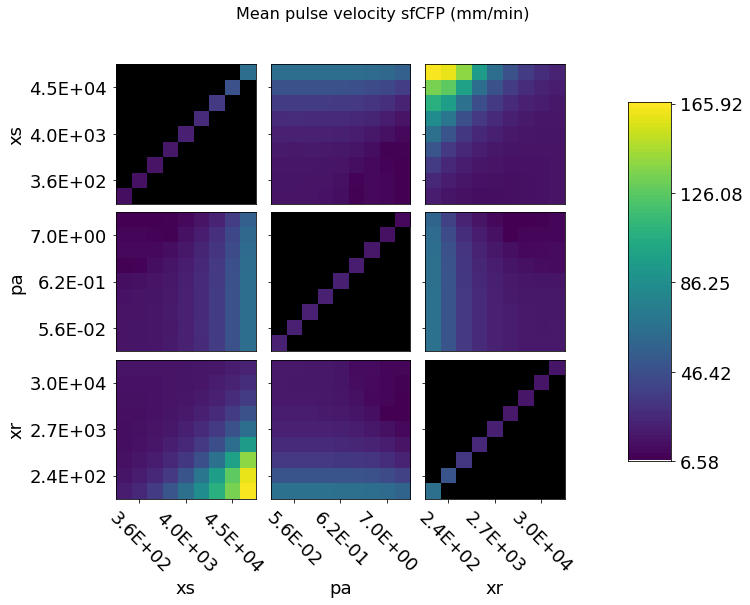

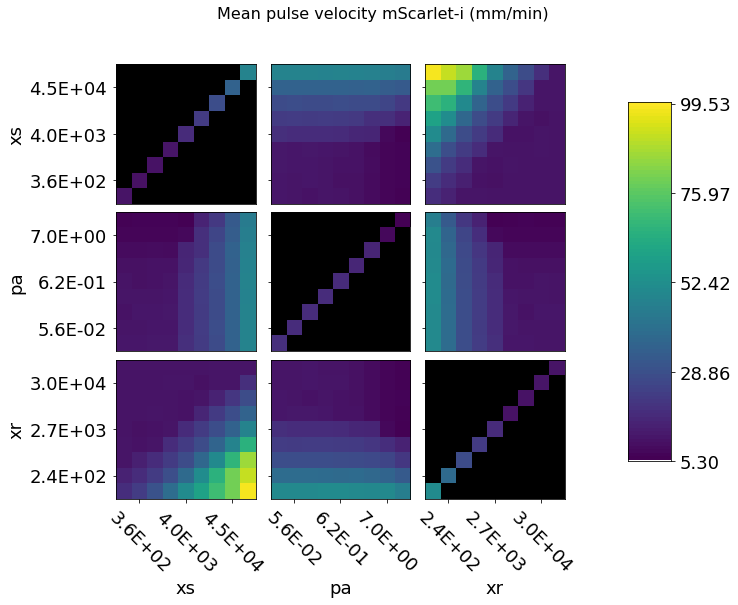

In [6]:
if noxs_flag:
    fit_df = pd.read_csv('fit_df_noxs.csv', index_col=0)
else:
    fit_df = pd.read_csv('nondim_fit_df.csv', index_col=0)

def make_plot(ax, x_var, y_var, c_var, var_list, fit_df):
    if x_var == y_var:
        ind = np.prod(
            [np.isclose(fit_df.loc[:,xx], def_parms[xx]) for xx in var_list if xx not in [x_var, c_var]],
            axis=0)>0
        if np.all(ind):
            ind = fit_df.index
        sub_df = fit_df.loc[ind, [x_var, c_var]]
        piv_df = sub_df.groupby(x_var, as_index=True).mean()
        t_inds = np.arange(1,n_powers,3)
        y_vec = piv_df.index.values
        n = len(y_vec)
        arr = np.empty((n,n)) * np.nan
        for i in np.arange(n):
            arr[i,i] = piv_df.values[i]
        y_labs = ["{:.1E}".format(xx) for xx in y_vec[t_inds]]
        c_all = fit_df.loc[:,c_var]
        vmin, vmax = np.array([f(c_all) for f in [np.min, np.max]], dtype=np.float)
        ax.imshow(arr, vmin=vmin, vmax=vmax, origin='lower')
        ax.set_yticks(t_inds)
        ax.set_yticklabels(y_labs)
        ax.set_xticks(t_inds)
        ax.set_xticklabels(y_labs, rotation=-45)
        ax.set_aspect(1)
        ax.set_facecolor('black')
    else:
        ind = np.prod(
            [np.isclose(fit_df.loc[:,xx], def_parms[xx]) for xx in var_list if xx not in [x_var, y_var, c_var]],
            axis=0)>0
        if np.all(ind):
            ind = fit_df.index
        sub_df = fit_df.loc[ind, [x_var, y_var, c_var]]
        piv_df = sub_df.groupby([x_var, y_var], as_index=False).mean().pivot(y_var, x_var, c_var)
        x_vec = piv_df.columns.values
        y_vec = piv_df.index.values
        t_inds = np.arange(1,n_powers,3)
        x_labs = ["{:.1E}".format(xx) for xx in x_vec[t_inds]]
        y_labs = ["{:.1E}".format(xx) for xx in y_vec[t_inds]]
        c_all = fit_df.loc[:,c_var]
        vmin, vmax = np.array([f(c_all) for f in [np.min, np.max]], dtype=np.float)
        ax.imshow(piv_df.values, vmin=vmin, vmax=vmax, origin='lower')
        ax.set_xticks(t_inds)
        ax.set_xticklabels(x_labs, rotation=-45)
        ax.set_yticks(t_inds)
        ax.set_yticklabels(y_labs)
        ax.set_aspect(1)

def make_cbar(ax, c_var, fit_df):
    c_vec = fit_df.loc[:,c_var]
    c_ext = np.array([f(c_vec) for f in [np.min, np.max]], dtype=np.float)
    if len(np.unique(c_vec.values)) == 2:
        n_colors = 2
        n_ticks = 2
        bar_width = 2
    else:
        n_colors = 100
        n_ticks = 5
        bar_width = n_colors//8
    int_x = np.linspace(c_ext[0],c_ext[1],n_ticks)
    im_vec = np.linspace(1,1/255,n_colors)
    im_arr = np.tile(im_vec, (bar_width,1)).T
    ax.imshow(im_arr, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks(np.linspace(1/255, n_colors, n_ticks))
    ax.set_yticklabels(["{:0.2f}".format(xx) for xx in int_x[::-1]])
    ax.yaxis.tick_right()

def make_grid_fig(vl_tmp, cvar, df_tmp):
    gs = mpl.gridspec.GridSpec(n_var*ax_width, n_var*ax_width+2)#, width_ratios=[1]*n_var + [0.1])
    for i, vy in enumerate(vl_tmp):
        for j, vx in enumerate(vl_tmp):
    #         ax = plt.subplot2grid((n_var, n_var+1),(i,j))
            ax = plt.subplot(gs[i*ax_width:i*ax_width+ax_width,j*ax_width:j*ax_width+ax_width])
            make_plot(ax, vx, vy, cvar, vl_tmp, df_tmp)
            if i == n_var-1:
                ax.set_xlabel(vx)
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(vy)
            else:
                ax.set_yticklabels([])

    # ax = plt.subplot2grid((n_var, n_var+1),(0,j+1), rowspan=n_var)
    ax = plt.subplot(gs[:,-1])
    make_cbar(ax, cvar, df_tmp)

vl_tmp = var_list # ["kC", 'xa', 'xr', 'xs']    
ind = np.prod(
    [np.isclose(fit_df.loc[:,xx], def_parms[xx]) for xx in var_list if xx not in vl_tmp],
    axis=0)>0
if ind.size < 2:
    ind = fit_df.index
n_var = len(vl_tmp)
ax_width = 3
cvar = 'sfcfp_mean_v'
cols = vl_tmp + pulse_features#par_list + ['reach', 'pulse', 'mean_v', 'amp', 'width'] 
df_tmp = fit_df.loc[ind,cols].copy().dropna(how='any', axis=0)
# df_tmp = df_tmp.loc[df_tmp.loc[:,'xs']>0,:]
# df_tmp = df_tmp.loc[fit_df.amp>0,:]
# df_tmp.loc[df_tmp.amp>0,"amp"] = np.log10(df_tmp.loc[df_tmp.amp>0,"amp"])
fig_size = (10,8)
fig = plt.figure(figsize=fig_size)
make_grid_fig(vl_tmp, cvar, df_tmp)
plt.suptitle('Mean pulse velocity sfCFP (mm/min)', fontsize=16)
if noxs_flag:
    fig.savefig("mean_vel_plot_all_noxs.pdf")
else:
    fig.savefig("mean_vel_plot_sfcfp.pdf")
    
    
cvar = 'mscarlet_mean_v'
cols = vl_tmp + pulse_features#par_list + ['reach', 'pulse', 'mean_v', 'amp', 'width'] 
df_tmp = fit_df.loc[ind,cols].copy().dropna(how='any', axis=0)
# df_tmp = df_tmp.loc[df_tmp.loc[:,'xs']>0,:]
# df_tmp = df_tmp.loc[fit_df.amp>0,:]
# df_tmp.loc[df_tmp.amp>0,"amp"] = np.log10(df_tmp.loc[df_tmp.amp>0,"amp"])
fig_size = (10,8)
fig = plt.figure(figsize=fig_size)
make_grid_fig(vl_tmp, cvar, df_tmp)
plt.suptitle('Mean pulse velocity mScarlet-i (mm/min)', fontsize=16)
if noxs_flag:
    fig.savefig("mean_vel_plot_all_noxs.pdf")
else:
    fig.savefig("mean_vel_plot_mscarlet.pdf")


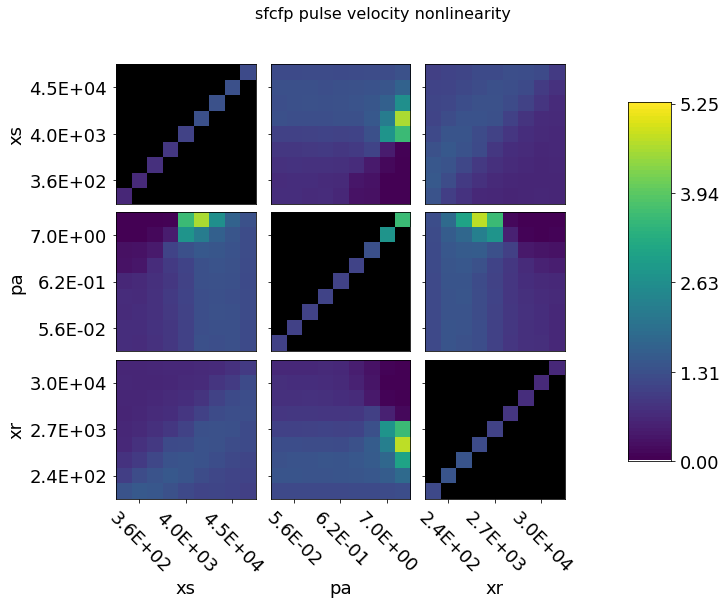

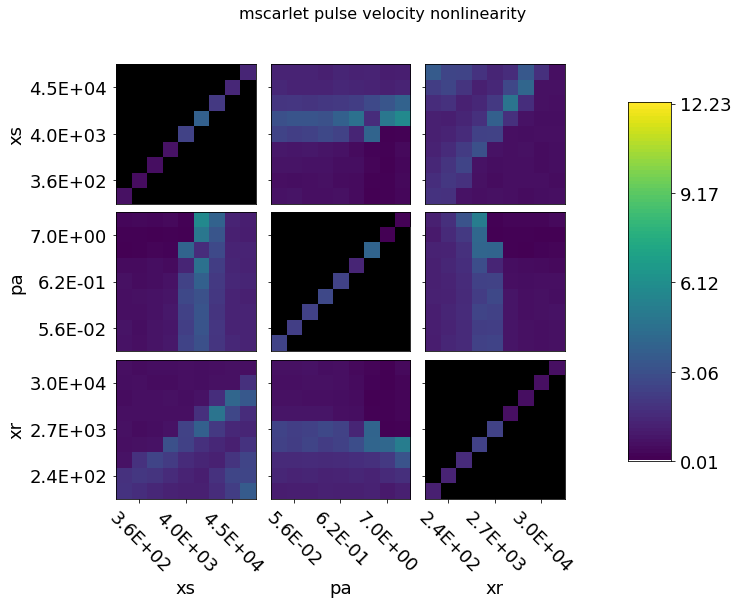

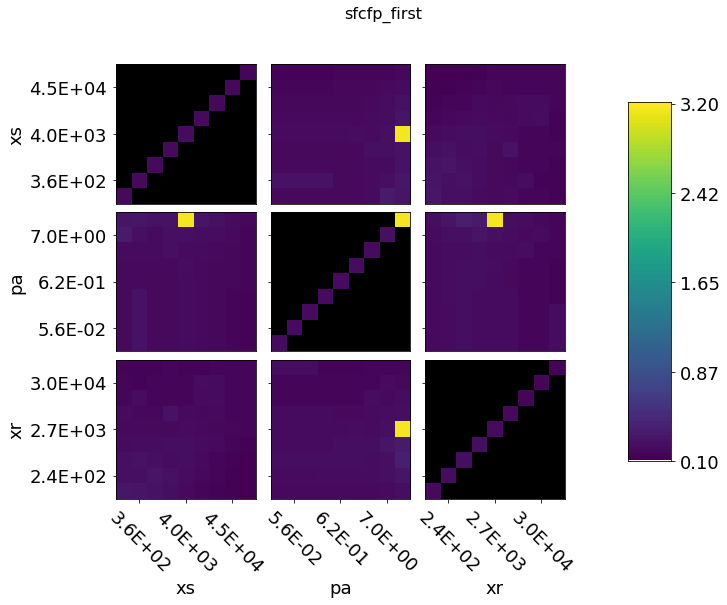

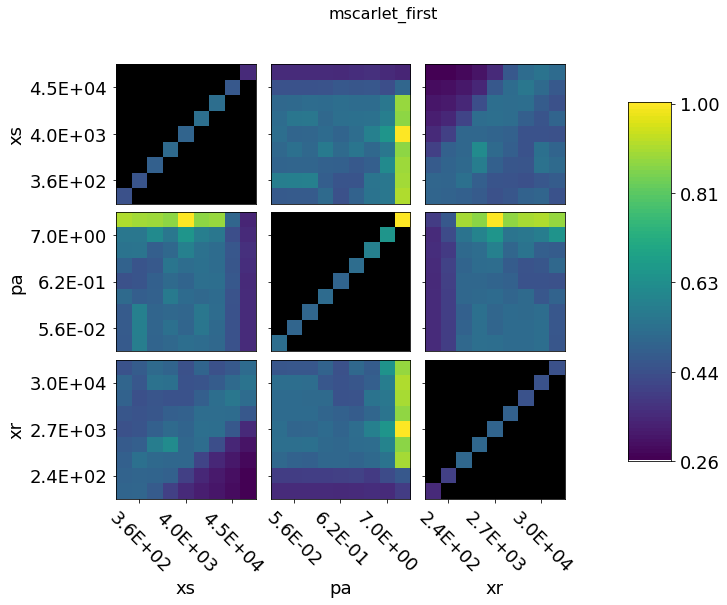

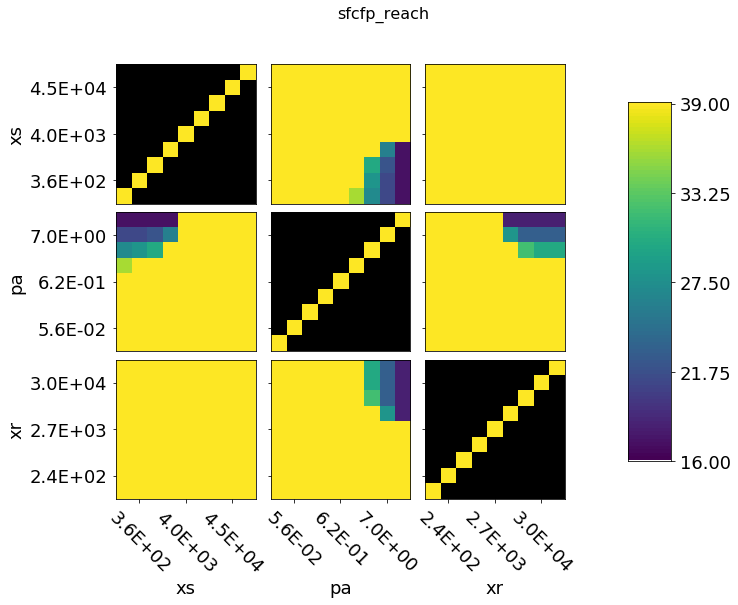

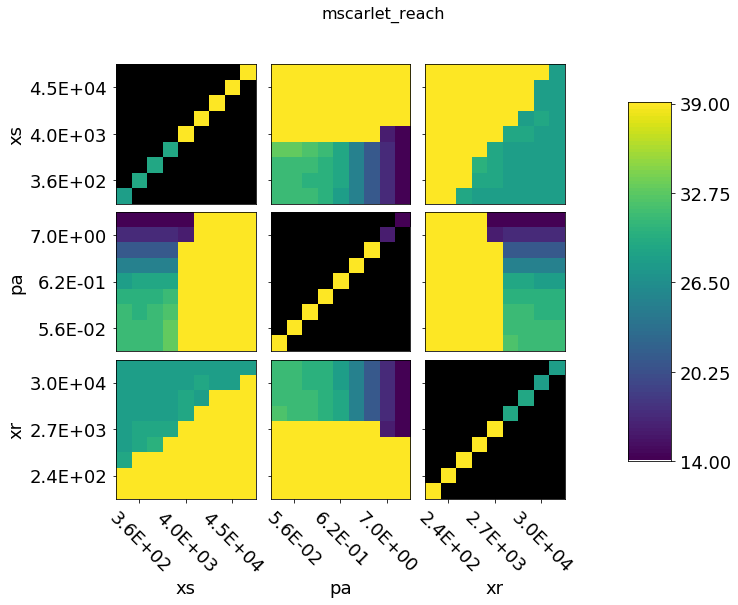

In [7]:

for channel in ['sfcfp', 'mscarlet']:
    fig = plt.figure(figsize=fig_size)
    cvar = '{}_c2'.format(channel)
    make_grid_fig(vl_tmp, cvar, df_tmp)
    plt.suptitle('{} pulse velocity nonlinearity'.format(channel), fontsize=16)
    if noxs_flag:
        fig.savefig("pulse_nonlinearity_plot_all_noxs.pdf")
    else:
        fig.savefig("pulse_nonlinearity_plot_all.pdf")
        
        
for channel in ['sfcfp', 'mscarlet']:
    fig = plt.figure(figsize=fig_size)
    cvar = '{}_first'.format(channel)
    make_grid_fig(vl_tmp, cvar, df_tmp)
    plt.suptitle(cvar, fontsize=16)
        
for channel in ['sfcfp', 'mscarlet']:
    fig = plt.figure(figsize=fig_size)
    cvar = '{}_reach'.format(channel)
    make_grid_fig(vl_tmp, cvar, df_tmp)
    plt.suptitle(cvar, fontsize=16)
#     if noxs_flag:
#         fig.savefig("pulse_nonlinearity_plot_all_noxs.pdf")
#     else:
#         fig.savefig("pulse_nonlinearity_plot_all.pdf")

(0, 1)

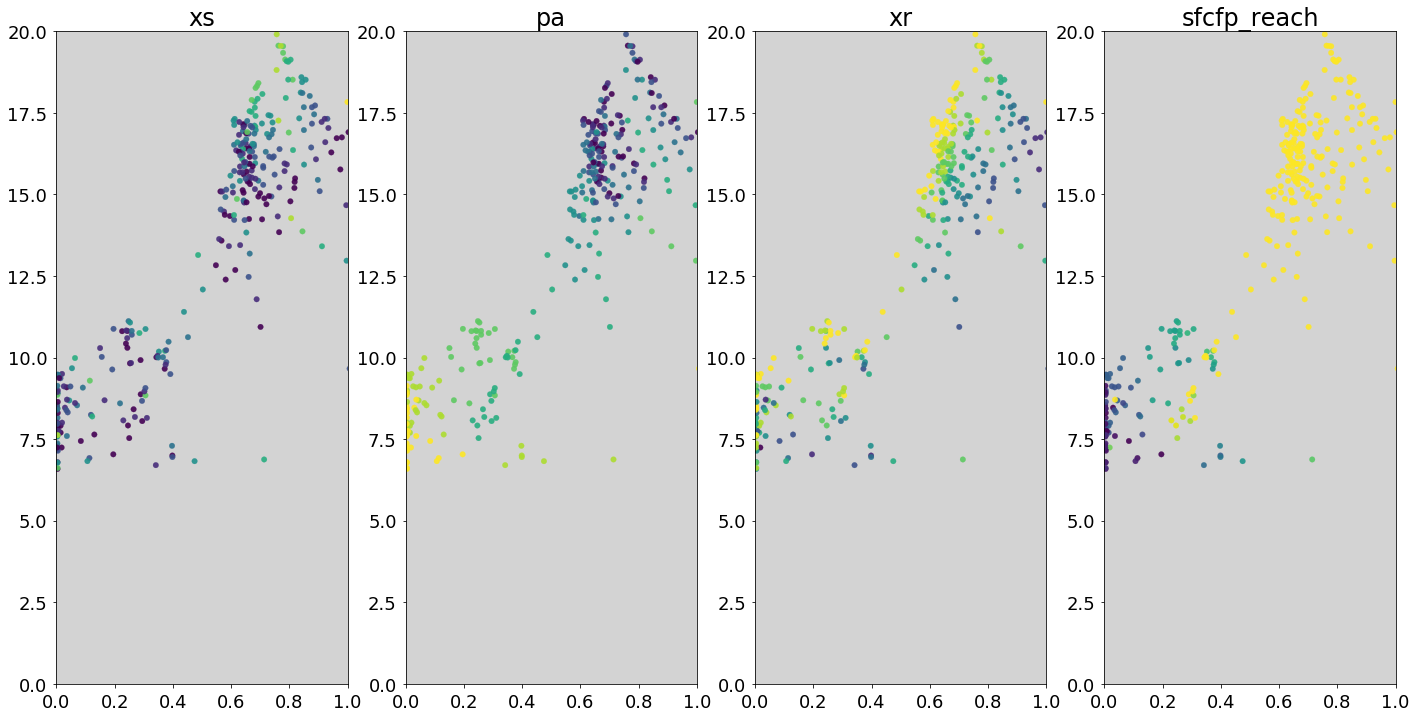

In [13]:
fig, axs = plt.subplots(1,1+len(var_list),figsize=(24,12))

df_tmp = fit_df.loc[:,:]

for i, var in enumerate(var_list):
    axs[i].scatter(df_tmp.loc[:,'sfcfp_c2'],
               df_tmp.loc[:,'sfcfp_mean_v'], 
               c=np.log10(df_tmp.loc[:,var]), alpha=0.9)
    axs[i].set_facecolor('lightgray')
    axs[i].set_title(var)
    axs[i].set_ylim([0,20])
    axs[i].set_xlim([0,1])
i = 3
var = 'sfcfp_reach'
axs[i].scatter(df_tmp.loc[:,'sfcfp_c2'],
           df_tmp.loc[:,'sfcfp_mean_v'], 
           c=df_tmp.loc[:,var], alpha=0.9)
axs[i].set_facecolor('lightgray')
axs[i].set_title(var)
axs[i].set_ylim([0,20])
axs[i].set_xlim([0,1])

76
200
675


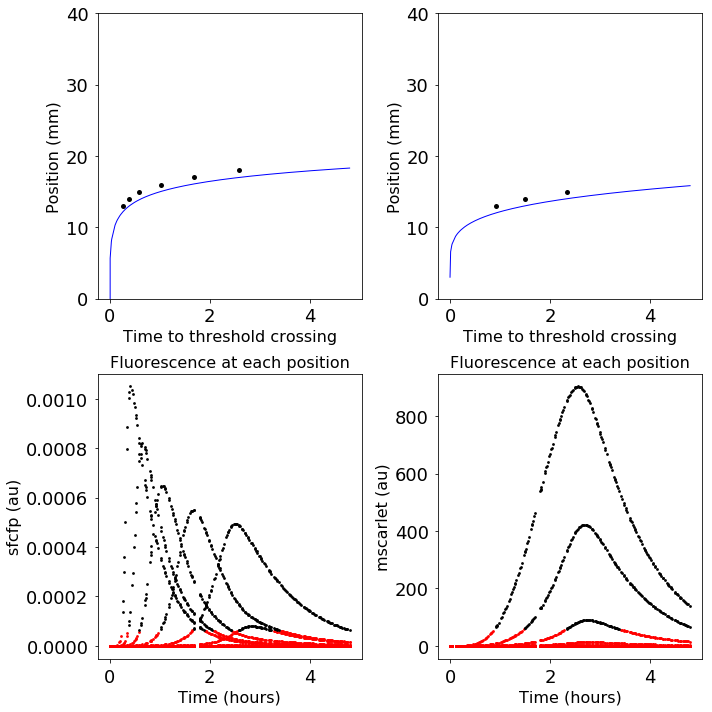

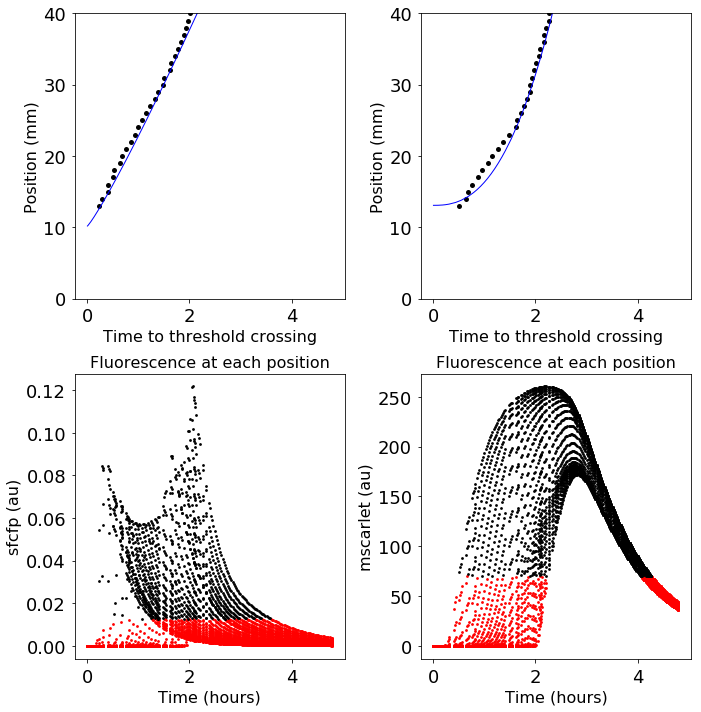

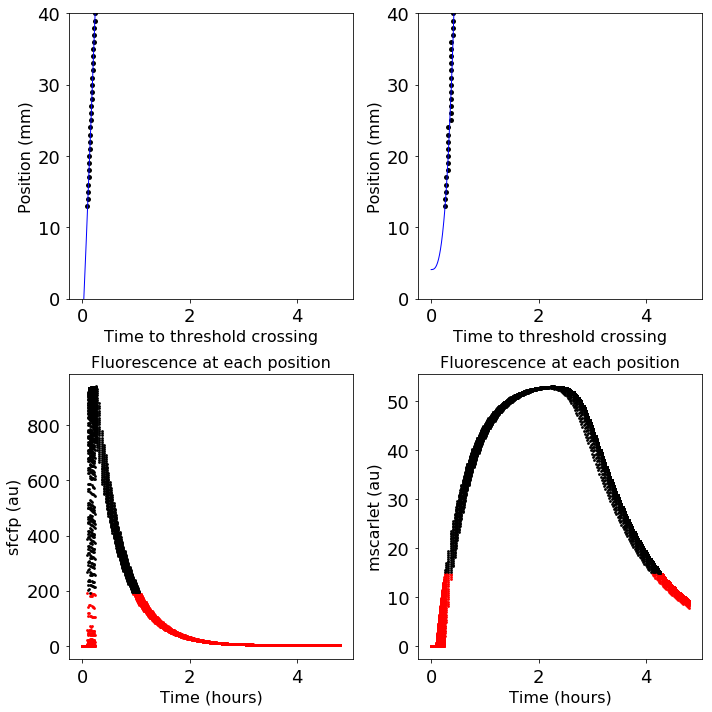

In [27]:

def find_crossings(arr, tvec, xvec):
    _, w = arr.shape
#     thresh = skimage.filters.threshold_otsu(arr) 
    thresh = skimage.filters.threshold_li(arr) 
    # arr[-1,:].min() #+ 10 # 250 # skimage.filters.threshold_li(arr)
    above_thresh = arr > thresh
    crossings = np.zeros(w)
    for j in np.arange(w):
        if np.any(above_thresh[:,j]):
            crossings[j] = tvec[above_thresh[:,j]].min()
            
    fit_x = xvec[crossings>0]
    fit_crossings = crossings[crossings>0]
    return fit_x, fit_crossings, crossings, above_thresh


def plot_crossings(i, fit_df):
    movie = np.load(img_fn.format(i))
    tvec = np.load(tvec_fn.format(i))
    scale,n_h,n_w,rp, Kn, Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od0 = parm_df.loc[i,:]
    scale,n_h,n_w = [int(x) for x in [scale,n_h,n_w]]

    full_xvec = np.arange(1, n_w+1)
    xvec_inds = slice(np.int(scale*1.2), n_w)
    xvec = full_xvec[xvec_inds]
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    for chan_i, channel, ax_i in ((s_i, 'sfcfp', 0), (r_i, 'mscarlet', 1)):
        ax = axs[0,ax_i]
        arr = movie[:,chan_i,1,xvec_inds]#.mean(axis=1)
        _, w = arr.shape
        fit_x, fit_crossings, crossings, above_thresh = find_crossings(arr, tvec, xvec)
        fit_p = fit_df.loc[i, ["{}_{}".format(channel, yy) for yy in par_list]]
        ax.plot(fit_crossings, fit_x, 'k.', ms=10)
        sim_t = tvec
        ax.plot(sim_t, f_fun(fit_p, sim_t), 'b-', lw=1)
#         ax.set_xlim([0,10])
        ax.set_ylim([0,n_w])
        font_dict = {'fontsize':16}
#         ax.set_xticks(np.arange(0,10,4))
#         ax.set_xticklabels(np.arange(0,10,4), fontdict=font_dict)
        ax.set_xlabel('Time to threshold crossing', fontdict=font_dict)
#         ax.set_yticks(np.arange(1,5,1)*(4.5))
#         ax.set_yticklabels(np.arange(1,5,1)*(4.5), fontdict=font_dict)
        ax.set_ylabel('Position (mm)', fontdict=font_dict)
#         ax.set_title("{}\nExponent term: {:.2f}".format(channel, fit_p[-1]), fontdict=font_dict)
        ax = axs[1,ax_i]
#         for j in np.arange(arr.shape[1]):
        arr_above = arr.copy()
        arr_above[above_thresh] = np.nan
        _ = ax.plot(tvec, arr_above, 'r.')
        arr_below = arr.copy()
        arr_below[False == above_thresh] = np.nan
        _ = ax.plot(tvec, arr_below, 'k.')
#         ax.set_xticks(np.arange(0,10,4))
#         ax.set_xticklabels(np.arange(0,10,4), fontdict=font_dict)
        ax.set_xlabel('Time (hours)', fontdict=font_dict)
        ax.set_ylabel('{} (au)'.format(channel), fontdict=font_dict)
        ax.set_title("Fluorescence at each position".format(channel, fit_p[-1]), fontdict=font_dict)
#         _ = ax.plot(tvec, len(tvec)*[thresh])
    fig.tight_layout()

diff_pd = fit_df.loc[:,'sfcfp_mean_v']
sort_pd = np.argsort(diff_pd)
sorted_ = diff_pd.iloc[sort_pd.values].values
# plt.plot(diff_pd.iloc[sort_pd.values].values,'.')
# print(sort_pd).
# sort_dict = dict(zip(sort_pd.values, sort_pd.index.values))
min_ind = sort_pd.index.values[sort_pd.values[0]]
mid_ind  = sort_pd.index.values[sort_pd.values[sort_pd.shape[0]//2]]
max_ind  = sort_pd.index.values[sort_pd.values[-1]]
print(min_ind)
print(mid_ind)
print(max_ind)    

plot_crossings(min_ind, fit_df)
plot_crossings(mid_ind, fit_df)
plot_crossings(max_ind, fit_df)
# plt.savefig("fit_param_{}.png".format(i))

# fit_df.loc[i, var_list] = parm_df.loc[i, var_list].values
# fit_df.loc[i, par_list] = fit_out.x
# fit_df.loc[i, "reach"] = np.float(crossings[-1]>0)

# fit_df.loc[i, "pulse"] = np.float((len(tvec) * 0.05) > np.sum(np.diff(peak_vec) < 1))
# if len(fit_x)>0:
#     fit_df.loc[i, "mean_v"] = fit_x.max()/fit_crossings.max()
#     fit_df.loc[i, "amp"] = arr_maxes.mean()
# else:
#     fit_df.loc[i, "mean_v"] = 0
#     fit_df.loc[i, "amp"] = 0

In [13]:
fit_df.loc[[max_ind,min_ind],var_list]

,xs,pa,xr
318,1788.854382,15.624999,1219.673323
684,100000.000000,0.625000,109.090898


In [14]:
jitt = np.random.random(fit_df.shape[0])/3
# plt.figure(figsize=(15,4))
plt.scatter(fit_df.loc[:,"mscarlet_mean_v"], 
            fit_df.loc[:,"sfcfp_mean_v"], 
            c=np.log10(fit_df.loc[:,"kR"]), alpha=0.6)
plt.gca().set_facecolor('lightgray')
plt.gca().set_aspect(1)
# plt.plot([0,0.2],[0,0.2],'k-')

KeyError: 'the label [kR] is not in the [columns]'

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(24,12))

axs[0].scatter(fit_df.loc[:,'sfcfp_mean_v'],
               fit_df.loc[:,'sfcfp_amp'], 
               c=np.log10(fit_df.loc[:,'xs']), alpha=0.9)
# axs[0].set_aspect(1)
axs[0].set_facecolor('lightgray')
axs[1].scatter(fit_df.loc[:,'sfcfp_mean_v'],
               fit_df.loc[:,'sfcfp_amp'], 
               c=np.log10(fit_df.loc[:,'kR']), alpha=0.9)
axs[1].set_facecolor('lightgray')
axs[2].scatter(fit_df.loc[:,'sfcfp_mean_v'],
               fit_df.loc[:,'sfcfp_amp'], 
               c=np.log10(fit_df.loc[:,'xr']), alpha=0.9)
axs[2].set_facecolor('lightgray')
axs[3].scatter(fit_df.loc[:,'sfcfp_mean_v'],
               fit_df.loc[:,'sfcfp_amp'], 
               c=fit_df.loc[:,'sfcfp_c2'], alpha=0.9)
axs[3].set_facecolor('lightgray')

In [ ]:
fig, axs = plt.subplots(1,5,figsize=(24,12))
for i, col in enumerate(var_list):
    _ = axs[i].hist(np.log10(df_tmp.loc[:,col]), bins=n_powers)
    axs[i].set_title(col)

In [ ]:
i = 272
movie = np.load(img_fn.format(i))
tvec = np.load(tvec_fn.format(i))
print(fit_df.loc[i,var_list])
anim = write_movie(movie, tvec, skip=4)
HTML(anim.to_html5_video())

In [ ]:
g = sns.PairGrid(np.log10(df_tmp.loc[df_tmp.loc[:,'xS'] > 1e3, var_list]), diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)


In [ ]:
fit_df